In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [2]:
df = pd.read_csv('X:\RA_AirQuality\combined_final_dataset.csv', index_col='DateTime')

In [3]:
df=df[pd.isnull(df['PM2.5'])==False]
# df = df.drop(columns=['Month','Hour'])
df=df.fillna(df.mean())
df.isnull().values.any()

False

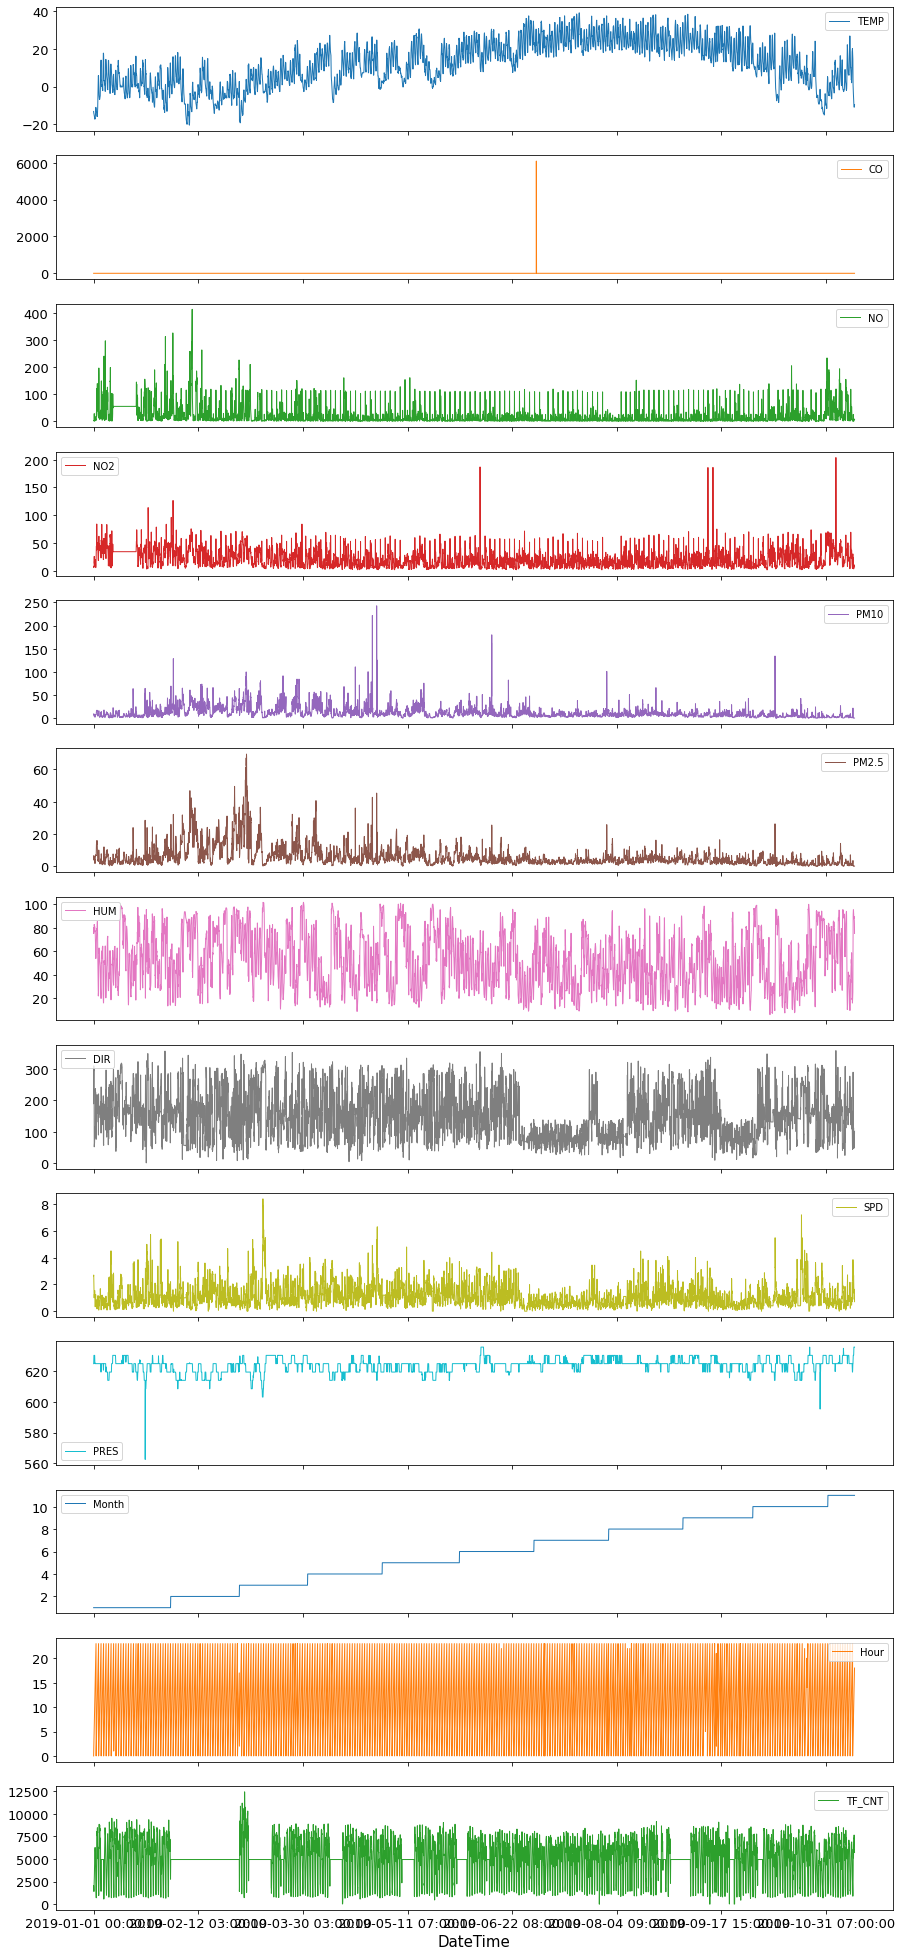

In [4]:
df.plot(figsize=(15,35), linewidth=1, fontsize=13, subplots=True)
plt.xlabel('DateTime', fontsize=15);

In [5]:
# GRANGER CAUSALITY TEST (Exhaustive Graphical Granger)

import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

gc = grangers_causation_matrix(df, variables = df.columns)   

In [6]:
gc

,TEMP_x,CO_x,NO_x,NO2_x,PM10_x,PM2.5_x,HUM_x,DIR_x,SPD_x,PRES_x,Month_x,Hour_x,TF_CNT_x
TEMP_y,1.0000,0.0074,0.0000,0.0000,0.0000,0.0000,0.0000,0.0828,0.0000,0.0000,0.0000,0.0000,0.0000
CO_y,0.1357,1.0000,0.8216,0.6910,0.7296,0.6635,0.2507,0.1267,0.7415,0.8206,0.7206,0.1434,0.1334
NO_y,0.0000,0.9864,1.0000,0.0000,0.0001,0.0000,0.0000,0.0214,0.0000,0.0000,0.0000,0.0000,0.0000
NO2_y,0.0000,0.5163,0.0000,1.0000,0.0000,0.0000,0.0000,0.0503,0.0000,0.0000,0.0000,0.0000,0.0000
PM10_y,0.0000,0.7810,0.0000,0.0000,1.0000,0.0000,0.0000,0.2894,0.0000,0.0000,0.0000,0.0000,0.0000
PM2.5_y,0.0000,0.8354,0.0000,0.0000,0.0000,1.0000,0.0000,0.4443,0.0000,0.0004,0.0000,0.0000,0.0000
HUM_y,0.0000,0.0003,0.0000,0.0000,0.0000,0.0000,1.0000,0.1109,0.0000,0.0000,0.0001,0.0000,0.0000
DIR_y,0.0000,0.9107,0.1707,0.0085,0.0008,0.0023,0.0002,1.0000,0.0000,0.0000,0.0000,0.0014,0.1351
SPD_y,0.0000,0.4728,0.0001,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0005,0.0000,0.0000
PRES_y,0.0000,0.9803,0.0000,0.0000,0.0000,0.0000,0.0000,0.1909,0.0000,1.0000,0.0000,0.0000,0.0000


In [7]:
import networkx as nx

In [23]:
# Directed Graphical Granger Model (All features included)

DG = nx.DiGraph()
DG.add_nodes_from(gc.columns)
i = 0
for x in gc:
    for y in range(11):
        if(gc[x][y] < 0.05):
            sizex = len(x)
            sizey = len(gc[x].index[y])
            DG.add_edge(x[:sizex - 2], gc[x].index[y][:sizey - 2])
#             print(x[:sizex - 2], 'causes', gc[x].index[y][:sizey - 2])

all_nodes = list(DG.nodes)
all_nodes = all_nodes[:11]
for x in all_nodes:
    DG.remove_node(x)
DG.remove_node('TF_CNT_x')
DG.remove_node('Hour_x')

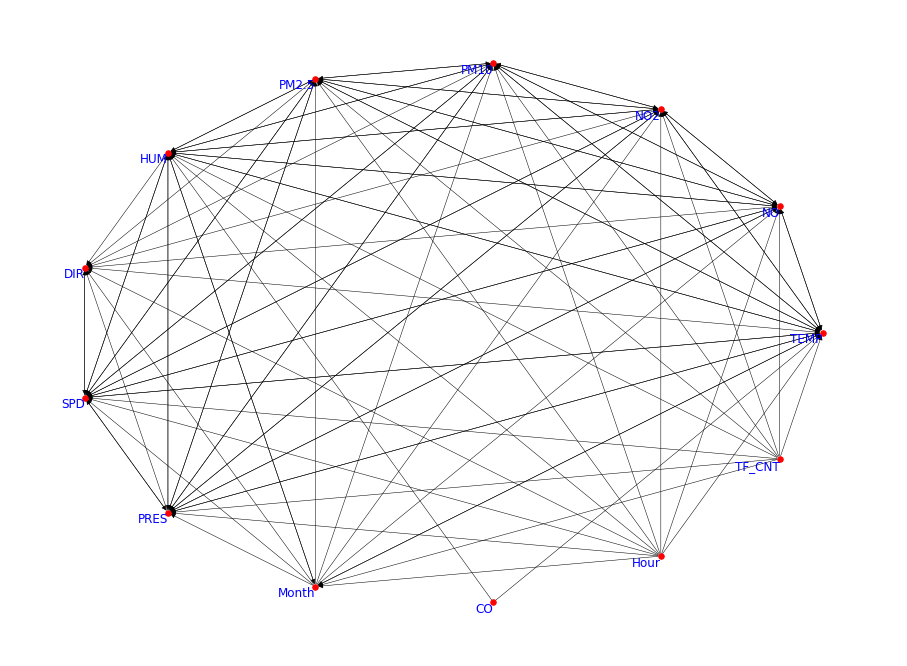

In [24]:
options = {
    'node_color': 'red',
    'node_size': 30,
    'width': 0.5,
}
plt.subplot()
nx.draw_circular(DG, with_labels=True,font_size=12, font_color='blue',horizontalalignment='right',verticalalignment='top', **options)

In [10]:
# Exhaustive Gragphical Granger (More lag takes enormous amount of time)
# Complex and hard to read

In [11]:
# Directed graphical granger model (PM2.5 isolated)

DG = nx.DiGraph()
DG.add_nodes_from(gc.columns)
i = 0
for x in gc:
    if(gc[x][5] < 0.05):
        sizex = len(x)
        DG.add_edge(x[:sizex - 2], 'PM2.5')
#         print(x[:sizex - 2], 'causes PM2.5')

all_nodes = list(DG.nodes)
all_nodes = all_nodes[:11]
for x in all_nodes:
    DG.remove_node(x)
DG.add_nodes_from(['CO','DIR'])
DG.remove_node('TF_CNT_x')
DG.remove_node('Hour_x')

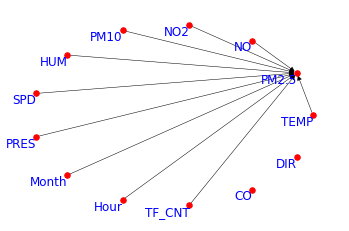

In [12]:
options = {
    'node_color': 'red',
    'node_size': 30,
    'width': 0.5,  
}
plt.subplot()
nx.draw_circular(DG, with_labels=True,font_size=12, font_color='blue',horizontalalignment='right',verticalalignment='top', **options)

In [13]:
# Isolated to PM2.5
# Except DIR and CO (for max lag = 12), all feature seem to cause PM2.5 (including TF_CNT)
# However, correlation matrix says otherwise

# Correlation matrix of residuals
#               TEMP        CO        NO       NO2      PM10     PM2.5       HUM       DIR       SPD      PRES     Month      Hour    TF_CNT
# TEMP      1.000000 -0.061801 -0.021887 -0.022253 -0.008569 -0.072230 -0.740641  0.033132 -0.054943 -0.047575 -0.155157  0.065565  0.032597
# CO       -0.061801  1.000000  0.016880 -0.025160 -0.001803  0.001357  0.071051  0.004068  0.006967 -0.000826 -0.006420  0.051230 -0.004983
# NO       -0.021887  0.016880  1.000000  0.522597  0.154159  0.219362  0.069248  0.014249 -0.048587 -0.012699 -0.051471  0.008636  0.002253
# NO2      -0.022253 -0.025160  0.522597  1.000000  0.193631  0.225423  0.059594  0.038726 -0.158140 -0.011917 -0.016097 -0.031281  0.007849
# PM10     -0.008569 -0.001803  0.154159  0.193631  1.000000  0.811144  0.045565  0.021860  0.086488  0.057766 -0.019211 -0.014334 -0.012581
# PM2.5    -0.072230  0.001357  0.219362  0.225423  0.811144  1.000000  0.180429  0.022050 -0.022794  0.003799 -0.048457  0.000288  0.001011
# HUM      -0.740641  0.071051  0.069248  0.059594  0.045565  0.180429  1.000000 -0.025541 -0.007803  0.034632  0.057476 -0.049994 -0.008276
# DIR       0.033132  0.004068  0.014249  0.038726  0.021860  0.022050 -0.025541  1.000000  0.154222 -0.005164 -0.011216  0.007939  0.029855
# SPD      -0.054943  0.006967 -0.048587 -0.158140  0.086488 -0.022794 -0.007803  0.154222  1.000000  0.028336  0.008396  0.021110  0.005396
# PRES     -0.047575 -0.000826 -0.012699 -0.011917  0.057766  0.003799  0.034632 -0.005164  0.028336  1.000000  0.028885 -0.019544  0.011791
# Month    -0.155157 -0.006420 -0.051471 -0.016097 -0.019211 -0.048457  0.057476 -0.011216  0.008396  0.028885  1.000000 -0.099773 -0.003955
# Hour      0.065565  0.051230  0.008636 -0.031281 -0.014334  0.000288 -0.049994  0.007939  0.021110 -0.019544 -0.099773  1.000000  0.004497
# TF_CNT    0.032597 -0.004983  0.002253  0.007849 -0.012581  0.001011 -0.008276  0.029855  0.005396  0.011791 -0.003955  0.004497  1.000000

<AxesSubplot:>

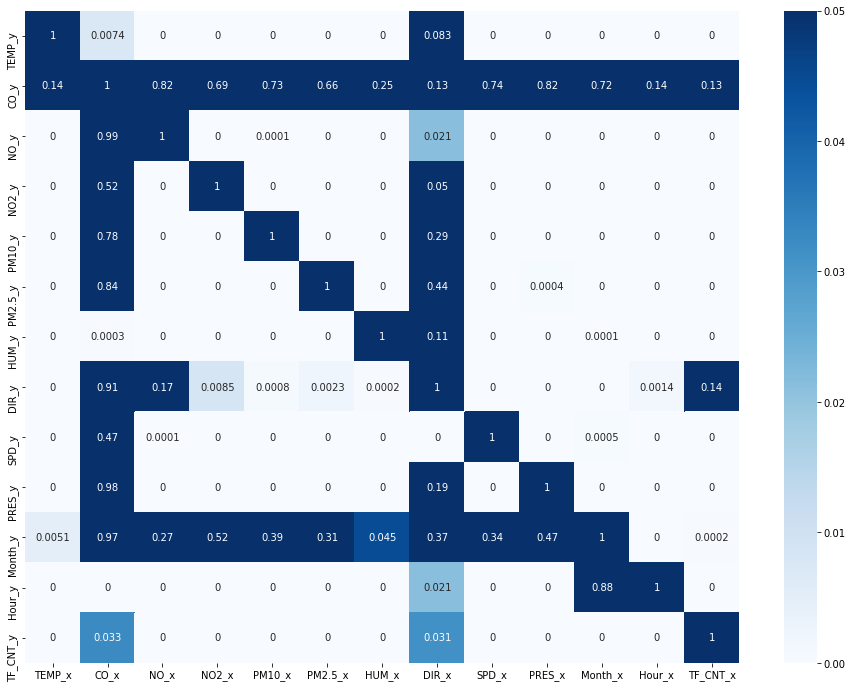

In [14]:
import matplotlib
matplotlib.rc('figure', figsize=(16, 12))

import seaborn as sns
# sns.heatmap(gc, cmap='Blues', annot=True)
sns.heatmap(gc, cmap='Blues', vmin=0, vmax=0.05, annot=True)

# Closer to zero = Higher Granger Causality Score (X causes Y with given score)
# Dark Blues are all rejection (X does not cause Y)

In [15]:
# DATA SPLIT into train and test

nobs = 2500
df_train, df_test = df[0:-nobs], df[-nobs:]

# Check size
print(df_train.shape)
print(df_test.shape)

(4773, 13)
(2500, 13)


In [16]:
# Select the Order (P) of VAR model by looking at AIC, BIC, FPE, HQIC scores
from statsmodels.tsa.api import VAR

model = VAR(df_train)
x = model.select_order(maxlags=50)
x.summary()

,AIC,BIC,FPE,HQIC
0,68.37,68.39,4.950e+29,68.38
1,43.99,44.23,1.267e+19,44.07
2,43.28,43.76*,6.240e+18,43.45
3,43.16,43.87,5.541e+18,43.41
4,43.06,44.00,5.029e+18,43.39
5,43.01,44.19,4.787e+18,43.42
6,42.94,44.35,4.460e+18,43.44
7,42.59,44.23,3.140e+18,43.17
8,42.45,44.32,2.729e+18,43.11*
9,42.44,44.54,2.697e+18,43.18


In [17]:
model_fitted = model.fit(25)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 09, Jul, 2021
Time:                     12:27:27
--------------------------------------------------------------------
No. of Equations:         13.0000    BIC:                    47.1889
Nobs:                     4748.00    HQIC:                   43.4458
Log likelihood:          -181671.    FPE:                9.74494e+17
AIC:                      41.4179    Det(Omega_mle):     4.11020e+17
--------------------------------------------------------------------
Results for equation TEMP
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const            -10.012426         2.999219           -3.338           0.001
L1.TEMP            1.236247         0.022833           54.143           0.000
L1.CO              0.000298         0.000192            1.548           0

In [18]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 12

# Input data for forecasting
forecast_input = df_train.values[-lag_order:]
forecast_input

25


array([[2.0940e+01, 6.0000e-02, 7.6000e-01, 1.1770e+01, 4.9000e+00,
        3.1000e+00, 5.6940e+01, 1.4709e+02, 7.2000e-01, 6.3031e+02,
        7.0000e+00, 1.0000e+01, 4.8940e+03],
       [2.0450e+01, 2.2000e-01, 2.8000e+00, 1.8170e+01, 4.8800e+00,
        3.1800e+00, 6.0520e+01, 1.5386e+02, 6.6000e-01, 6.3031e+02,
        7.0000e+00, 1.1000e+01, 6.1480e+03],
       [1.9800e+01, 4.2000e-01, 6.5400e+00, 2.0610e+01, 5.8900e+00,
        3.5400e+00, 6.2200e+01, 1.5508e+02, 7.0000e-01, 6.3040e+02,
        7.0000e+00, 1.2000e+01, 6.4640e+03],
       [2.0120e+01, 4.8000e-01, 2.2800e+01, 2.7920e+01, 7.2200e+00,
        3.9800e+00, 5.8200e+01, 1.4869e+02, 7.3000e-01, 6.3040e+02,
        7.0000e+00, 1.3000e+01, 6.6190e+03],
       [2.2540e+01, 4.7000e-01, 4.8560e+01, 3.0100e+01, 1.0030e+01,
        4.4200e+00, 5.0860e+01, 1.5977e+02, 9.4000e-01, 6.3040e+02,
        7.0000e+00, 1.4000e+01, 6.5160e+03],
       [2.4830e+01, 4.4000e-01, 2.6980e+01, 2.6630e+01, 9.8600e+00,
        4.3000e+00, 4.3900e

In [19]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_forecast')
df_forecast

,TEMP_forecast,CO_forecast,NO_forecast,NO2_forecast,PM10_forecast,PM2.5_forecast,HUM_forecast,DIR_forecast,SPD_forecast,PRES_forecast,Month_forecast,Hour_forecast,TF_CNT_forecast
DateTime,,,,,,,,,,,,,
2019-07-25 11:00:00,21.457692,22.019037,16.599232,21.145979,8.350013,3.500083,55.164608,160.756624,0.768976,625.042156,6.997682,11.440811,6432.949603
2019-07-25 12:00:00,20.890989,7.740812,22.340135,22.384868,10.297344,3.582222,58.877175,137.695061,0.777089,625.185685,6.997089,11.490018,6410.424277
2019-07-25 13:00:00,21.485889,19.206845,26.265055,23.075230,10.569463,3.330595,58.129829,150.144937,0.719343,625.526981,6.991000,13.009618,6519.792079
2019-07-25 14:00:00,23.119606,27.326787,30.969419,22.975011,14.019121,4.053832,52.199400,151.217866,0.755688,625.812784,6.993049,13.612362,6057.322971
2019-07-25 15:00:00,25.301608,-10.291212,18.149797,17.430604,8.974577,2.931569,45.095754,140.382550,0.833424,625.730332,6.994687,14.703257,5334.328402
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-11-11 14:00:00,33.082096,5.245422,-11.024587,4.952959,8.000718,1.659770,41.238918,108.112064,1.002697,625.726408,8.897527,12.051839,4789.410356
2019-11-11 15:00:00,33.190689,5.287460,-11.179236,4.820837,8.031584,1.652077,40.932567,108.092404,1.012103,625.715413,8.898214,12.065284,4756.288113
2019-11-11 16:00:00,33.289867,5.327125,-11.341382,4.709393,8.049897,1.642141,40.661762,108.067238,1.020480,625.705039,8.898943,12.038621,4720.355693


In [20]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
#     for col in columns:        
#         # Roll back 2nd Diff
#         if second_diff:
#             df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
# #         Roll back 1st Diff
#         df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [21]:
df_results = invert_transformation(df_train, df_forecast, second_diff=False)        
df_results.loc[:, ['TEMP_forecast', 'CO_forecast', 'NO_forecast', 'NO2_forecast', 'PM10_forecast', 'PM2.5_forecast', 'HUM_forecast', 'DIR_forecast', 'SPD_forecast', 'PRES_forecast', 'TF_CNT_forecast']]

,TEMP_forecast,CO_forecast,NO_forecast,NO2_forecast,PM10_forecast,PM2.5_forecast,HUM_forecast,DIR_forecast,SPD_forecast,PRES_forecast,TF_CNT_forecast
DateTime,,,,,,,,,,,
2019-07-25 11:00:00,21.457692,22.019037,16.599232,21.145979,8.350013,3.500083,55.164608,160.756624,0.768976,625.042156,6432.949603
2019-07-25 12:00:00,20.890989,7.740812,22.340135,22.384868,10.297344,3.582222,58.877175,137.695061,0.777089,625.185685,6410.424277
2019-07-25 13:00:00,21.485889,19.206845,26.265055,23.075230,10.569463,3.330595,58.129829,150.144937,0.719343,625.526981,6519.792079
2019-07-25 14:00:00,23.119606,27.326787,30.969419,22.975011,14.019121,4.053832,52.199400,151.217866,0.755688,625.812784,6057.322971
2019-07-25 15:00:00,25.301608,-10.291212,18.149797,17.430604,8.974577,2.931569,45.095754,140.382550,0.833424,625.730332,5334.328402
...,...,...,...,...,...,...,...,...,...,...,...
2019-11-11 14:00:00,33.082096,5.245422,-11.024587,4.952959,8.000718,1.659770,41.238918,108.112064,1.002697,625.726408,4789.410356
2019-11-11 15:00:00,33.190689,5.287460,-11.179236,4.820837,8.031584,1.652077,40.932567,108.092404,1.012103,625.715413,4756.288113
2019-11-11 16:00:00,33.289867,5.327125,-11.341382,4.709393,8.049897,1.642141,40.661762,108.067238,1.020480,625.705039,4720.355693


In [22]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
#     mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
#     me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
#     mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
#     corr = np.corrcoef(forecast, actual)[0,1]   # corr
#     mins = np.amin(np.hstack([forecast[:,None], 
#                               actual[:,None]]), axis=1)
#     maxs = np.amax(np.hstack([forecast[:,None], 
#                               actual[:,None]]), axis=1)
#     minmax = 1 - np.mean(mins/maxs)             # minmax
    return({
#        'mape':mape, 
#        'me':me, 
        'mae': mae, 
#        'mpe': mpe, 
        'rmse':rmse, 
#       'corr':corr, 
#       'minmax':minmax
           })

# print('Forecast Accuracy of: TEMP')
# accuracy_prod = forecast_accuracy(df_results['TEMP_forecast'].values, df_test['TEMP'])
# for k, v in accuracy_prod.items():
#     print(k, ': ', round(v,4))

print('\nForecast Accuracy of: PM2.5')
accuracy_prod = forecast_accuracy(df_results['PM2.5_forecast'].values, df_test['PM2.5'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))


Forecast Accuracy of: PM2.5
mae :  1.534
rmse :  2.332
